# **Spatial Analysis with rapids-singlecell and Squidpy**
**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

In this notebook, we demonstrate GPU-accelerated spatial analysis using **rapids-singlecell** alongside **Squidpy**.

We cover two key spatial analysis techniques:

1. **Spatial Autocorrelation** — We compute **Moran's I** and **Geary's C** to assess the spatial organization of gene expression patterns. While Moran's I captures global spatial structure, Geary's C is more sensitive to local differences, highlighting regions with abrupt expression changes. Together, these metrics reveal biological patterns such as niche-specific expression and spatial gradients.

2. **Co-occurrence Analysis** — We compute the **co-occurrence probability** of cell type pairs across varying spatial distances. This analysis identifies which cell types tend to co-localize or spatially exclude each other, providing insights into cell-cell interactions and tissue organization.

Both analyses leverage the GPU-accelerated implementations in **rapids-singlecell**, delivering significant speedups over CPU-based methods while producing equivalent results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rapids_singlecell as rsc
import cupy as cp
import squidpy as sq
import numpy as np
import anndata as ad

/home/sdicks/micromamba/envs/rapids-26.02/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:531: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
/home/sdicks/micromamba/envs/rapids-26.02/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = partial(_left_exclusive_join_spatialelement_table)
/home/sdicks/micromamba/envs/rapids-26.02/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:533: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  inner = partial(_inner_join_spatialelement_table)
/home/

In [3]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=[0,1],  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [4]:
adata = sq.datasets.visium_hne_adata()
sq.gr.spatial_neighbors(adata)

INFO     Creating graph using `grid` coordinates and `None` transform and `1` libraries.                           


In [5]:
genes = adata.var_names

## Moran's I
To assess spatial structure in gene expression, we compute **spatial autocorrelation**,  
which measures how gene expression levels are spatially distributed across tissue sections.  

In [6]:
%%time
rsc.gr.spatial_autocorr(adata, 
                        mode="moran", 
                        connectivity_key="connectivities", 
                        dtype=np.float32, 
                        genes=genes, 
                        n_perms=100, 
                        use_sparse=True)

CPU times: user 405 ms, sys: 58 ms, total: 463 ms
Wall time: 463 ms


## Geary's C

In addition to **Moran’s I**, we compute **Geary’s C**, another spatial autocorrelation metric.  
While Moran’s I captures **global spatial structure**, **Geary’s C** is more sensitive to **local differences**,  
highlighting regions with abrupt expression changes.  

`use_sparse=True` Enables sparse computation, preventing full matrix densification.
This optimization is handled efficiently in the GPU kernel, significantly reducing memory usage.
Moran’s I also supports use_sparse=True, allowing for efficient computation on large datasets.

In [7]:
%%time
rsc.gr.spatial_autocorr(adata, 
                        mode="geary",
                        connectivity_key="connectivities",
                        genes=genes,
                        dtype=np.float32, 
                        n_perms=100, 
                        use_sparse=True)

CPU times: user 301 ms, sys: 8.98 ms, total: 310 ms
Wall time: 309 ms


## Co-occurrence Analysis

Co-occurrence analysis measures the probability of observing pairs of cell types at varying spatial distances.
This helps identify cell types that tend to **co-localize** (high co-occurrence) or **spatially exclude** each other (low co-occurrence), revealing patterns of tissue organization and potential cell-cell interactions.

We compute the co-occurrence probability using both **rapids-singlecell** (GPU) and **Squidpy** (CPU) to compare performance.

In [8]:
%%time
rsc.gr.co_occurrence(adata, cluster_key="leiden")

CPU times: user 7.66 ms, sys: 1.03 ms, total: 8.69 ms
Wall time: 8.59 ms


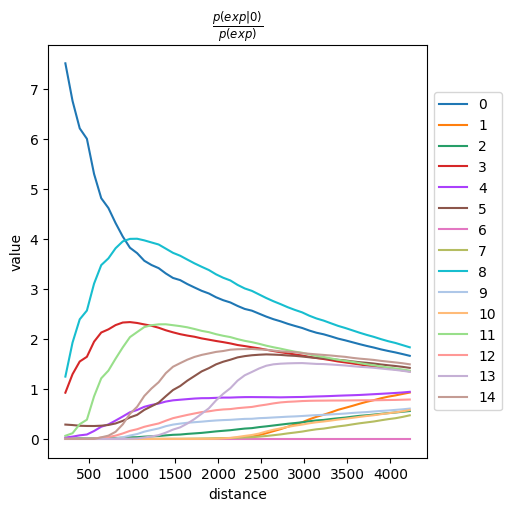

In [10]:
sq.pl.co_occurrence(adata, cluster_key="leiden", clusters="0")